https://www.kaggle.com/c/bike-sharing-demand/data?select=train.csv

- datetime: 대여 기록의 날짜와 시간 정보
- season: 계절(1~4)
- holiday: 공휴일 여부 (0, 1)
- workingday: 평일 여부(근무일) (0, 1)
- weather: 기상상황 (1~4)
- temp, atemp: 온도와 체감온도
- humidity: 습도
- windspeed: 풍속
- casual, registered: 비회원, 회원 대여량(train 데이터에만 있음)
- count: 총 대여량(타겟, train 데이터에만 있음)

In [33]:
# 자전거 대여량 예측 모델 

In [34]:
# LinearRegression,RandomForestRegressor
# GradientBoostingRegressor, XGBRegressor, LGBMRegressor


<br/>

---

<br/>
<br/>

# 0. 라이브러리 불러오기

In [35]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_squared_log_error
import warnings
warnings.filterwarnings("ignore")


<br/>

---

<br/>
<br/>

# 1. 데이터 불러오기

In [36]:
# 데이터 불러오기
import pandas as pd

train_df = pd.read_csv("./data/bike-sharing-demand/train.csv")
test_df = pd.read_csv("./data/bike-sharing-demand/test.csv")

<br/>

---

<br/>
<br/>

# 2. 데이터 탐색하기

In [ ]:
# 기본 정보 확인
print(train_df.head(2))
train_df.info()
train_df.describe()

              datetime  season  holiday  workingday  weather  temp   atemp  \
0  2011-01-01 00:00:00       1        0           0        1  9.84  14.395   
1  2011-01-01 01:00:00       1        0           0        1  9.02  13.635   

   humidity  windspeed  casual  registered  count  
0        81        0.0       3          13     16  
1        80        0.0       8          32     40  


<br/>

---

<br/>
<br/>

# 3. 데이터 전처리

In [38]:
# 결측치 및 이상치 확인
train_df.isnull().sum()
# 결측치 없음

datetime      0
season        0
holiday       0
workingday    0
weather       0
temp          0
atemp         0
humidity      0
windspeed     0
casual        0
registered    0
count         0
dtype: int64

In [39]:
test_df.head(2)
test_df.info()
test_df.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6493 entries, 0 to 6492
Data columns (total 9 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   datetime    6493 non-null   object 
 1   season      6493 non-null   int64  
 2   holiday     6493 non-null   int64  
 3   workingday  6493 non-null   int64  
 4   weather     6493 non-null   int64  
 5   temp        6493 non-null   float64
 6   atemp       6493 non-null   float64
 7   humidity    6493 non-null   int64  
 8   windspeed   6493 non-null   float64
dtypes: float64(3), int64(5), object(1)
memory usage: 456.7+ KB


,season,holiday,workingday,weather,temp,atemp,humidity,windspeed
count,6493.000000,6493.000000,6493.000000,6493.000000,6493.000000,6493.000000,6493.000000,6493.000000
mean,2.493300,0.029108,0.685815,1.436778,20.620607,24.012865,64.125212,12.631157
std,1.091258,0.168123,0.464226,0.648390,8.059583,8.782741,19.293391,8.250151
min,1.000000,0.000000,0.000000,1.000000,0.820000,0.000000,16.000000,0.000000
25%,2.000000,0.000000,0.000000,1.000000,13.940000,16.665000,49.000000,7.001500
50%,3.000000,0.000000,1.000000,1.000000,21.320000,25.000000,65.000000,11.001400
75%,3.000000,0.000000,1.000000,2.000000,27.060000,31.060000,81.000000,16.997900
max,4.000000,1.000000,1.000000,4.000000,40.180000,50.000000,100.000000,55.998600


In [40]:
test_df.isnull().sum()
# 결측치 없음

datetime      0
season        0
holiday       0
workingday    0
weather       0
temp          0
atemp         0
humidity      0
windspeed     0
dtype: int64

In [41]:
# datetime에서 파생 변수 생성
def feature_engineering(df):
    df['datetime'] = pd.to_datetime(df['datetime'])
    df['year'] = df['datetime'].dt.year
    df['month'] = df['datetime'].dt.month
    df['day'] = df['datetime'].dt.day
    df['hour'] = df['datetime'].dt.hour
    df['weekday'] = df['datetime'].dt.weekday
    df = df.drop(['datetime'], axis=1)
    return df

train = feature_engineering(train_df.copy())
test = feature_engineering(test_df.copy())

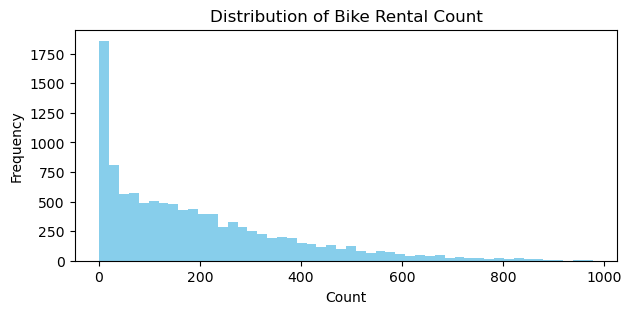

In [57]:
# 대여량 분포 확인
import matplotlib.pyplot as plt

plt.figure(figsize=(7,3))
plt.hist(train['count'], bins=50, color='skyblue')
plt.title('Distribution of Bike Rental Count')
plt.xlabel('Count')
plt.ylabel('Frequency')
plt.show()

- 자전거 대여량의 분포 - 오른쪽으로 긴 꼬리를 가진 형태
- 적은 대여량이 많은 시간대에 자주 나타남
- 아주 높은 대여량이 드물게 나타남

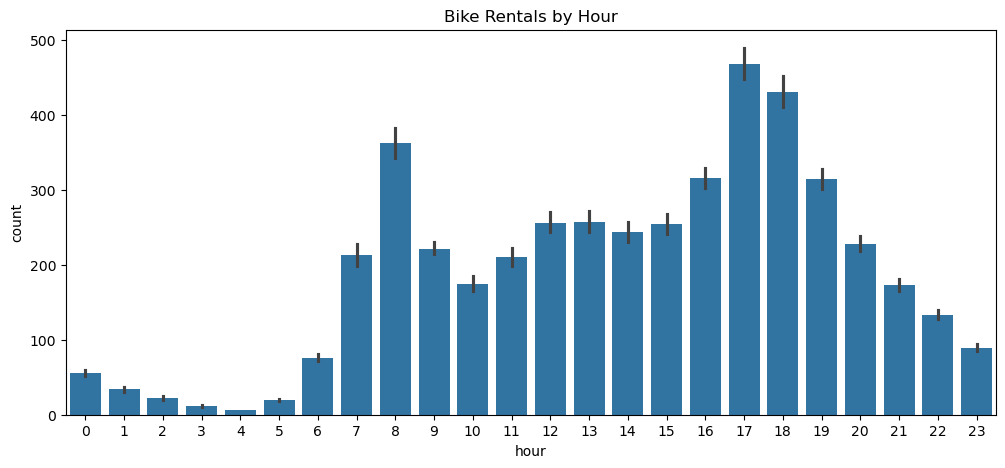

In [43]:
import matplotlib.pyplot as plt

# 시간대별 대여량 확인
import seaborn as sns

plt.figure(figsize=(12,5))
sns.barplot(x='hour', y='count', data=train)
plt.title('Bike Rentals by Hour')
plt.show()

출근(8시), 퇴근(17~19시) 시간에 대여가 급증하는 경향
17시에 가장 높은 대여량

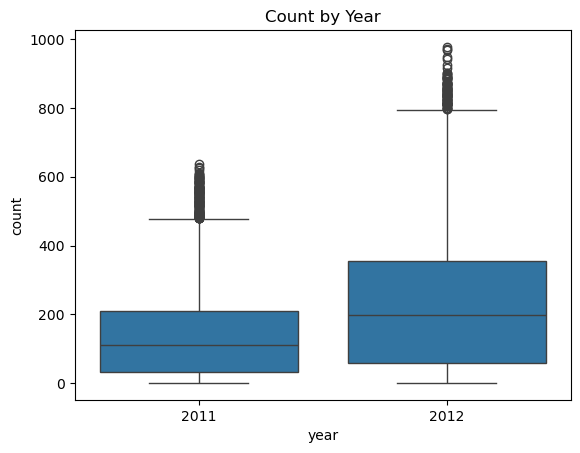

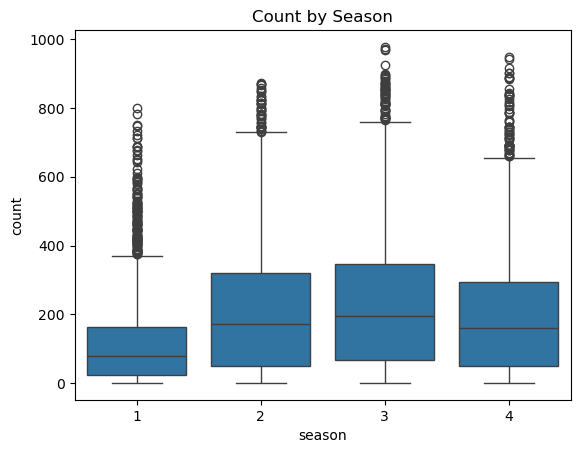

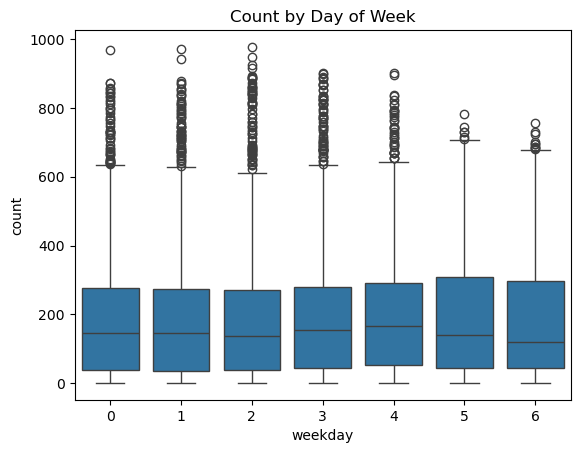

In [44]:
import matplotlib.pyplot as plt

# 연도별 대여량
sns.boxplot(x='year', y='count', data=train)
plt.title('Count by Year')
plt.show()

# 게절별 대여량
sns.boxplot(x='season', y='count', data=train)
plt.title('Count by Season')
plt.show()

# 요일별 대여량
sns.boxplot(x='weekday', y='count', data=train)
plt.title('Count by Day of Week')
plt.show()

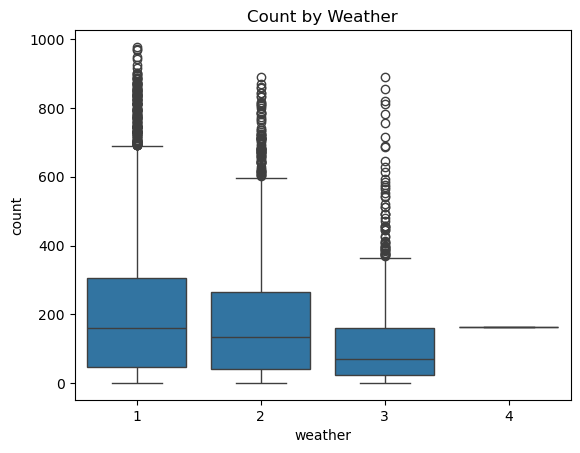

In [45]:
# 기상상황에 따른 대여량
sns.boxplot(x='weather', y='count', data=train)
plt.title('Count by Weather')
plt.show()

날씨가 4일 때 대여량이 낮음

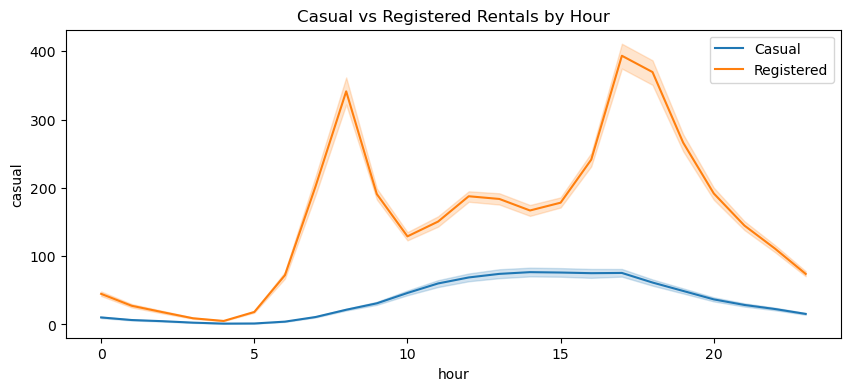

In [46]:

plt.figure(figsize=(10,4))
sns.lineplot(x='hour', y='casual', data=train, label='Casual')
sns.lineplot(x='hour', y='registered', data=train, label='Registered')
plt.legend()
plt.title('Casual vs Registered Rentals by Hour')
plt.show()

비회원과 회원의 대여량 패턴이 다름
비회원 - 낮 시간 때에 대여량 높음
회원 - 출퇴근 시간에 대여량 높음

              count      temp     atemp  humidity  windspeed
count      1.000000  0.394454  0.389784 -0.317371   0.101369
temp       0.394454  1.000000  0.984948 -0.064949  -0.017852
atemp      0.389784  0.984948  1.000000 -0.043536  -0.057473
humidity  -0.317371 -0.064949 -0.043536  1.000000  -0.318607
windspeed  0.101369 -0.017852 -0.057473 -0.318607   1.000000


<Axes: >

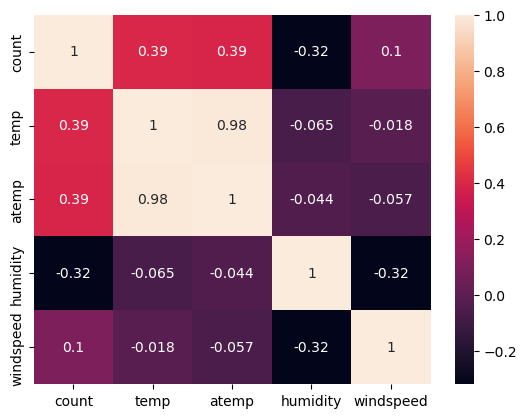

In [47]:
# 날씨, 온도, 습도, 풍속과의 상관관계
correlations = train[['count', 'temp', 'atemp', 'humidity', 'windspeed']].corr()
print(correlations)
sns.heatmap(correlations, annot=True)

- count와 temp/atemp의 중간 정도의 양의 상관관계
-> 온도와 체감온도가 높을수록 자전거 대여량이 어느 정도 증가함

- temp와 atemp 강한 양의 상관관계

In [48]:
# 타겟 변수
y = train['count']
X = train.drop(['casual', 'registered', 'count'], axis=1)

In [49]:
# 데이터 분리
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

X_train = np.asarray(X_train)
X_val = np.asarray(X_val)
y_train = np.asarray(y_train)
y_val = np.asarray(y_val)

In [ ]:
# 다항회귀모델
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import make_pipeline
from sklearn.metrics import mean_squared_error, r2_score

results = []

for degree in range(1,5):  # 2차~5차
    model = make_pipeline(PolynomialFeatures(degree=degree, include_bias=False),
                          LinearRegression())
    model.fit(X_train, y_train)
    pred = model.predict(X_val)

    mse = mean_squared_error(y_val, pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_val, pred)

    results.append({
        'Degree': degree,
        'MSE': mse,
        'RMSE': rmse,
        'R2': r2
    })

results_df = pd.DataFrame(results)
results_df

,Degree,MSE,RMSE,R2
0,1,19940.436220,141.210609,0.395871
1,2,14452.353627,120.217942,0.562142
2,3,12232.874930,110.602328,0.629385
3,4,474972.398724,689.182413,-13.390079


In [51]:
models = {
    "LinearRegression": LinearRegression(),
    "RandomForest": RandomForestRegressor(n_estimators=100, random_state=42),
    "GradientBoosting": GradientBoostingRegressor(n_estimators=100, random_state=42),
    "XGBoost": XGBRegressor(n_estimators=100, random_state=42),
    "LightGBM": LGBMRegressor(n_estimators=100, random_state=42)
}

def evaluate_model(name, model):
    model.fit(X_train, y_train)
    pred = model.predict(X_val)

    mse = mean_squared_error(y_val, pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_val, pred)

    print(f"{name}")
    print(f"  MSE :  {mse:.5f}")
    print(f"  RMSE:  {rmse:.5f}")
    print(f"  R^2 :  {r2:.5f}")
    print("-" * 30)


In [52]:
for name, model in models.items():
    evaluate_model(name, model)

LinearRegression
  MSE :  19940.43622
  RMSE:  141.21061
  R^2 :  0.39587
------------------------------
RandomForest
  MSE :  1499.45572
  RMSE:  38.72281
  R^2 :  0.95457
------------------------------
GradientBoosting
  MSE :  4672.31980
  RMSE:  68.35437
  R^2 :  0.85844
------------------------------
XGBoost
  MSE :  1407.53772
  RMSE:  37.51717
  R^2 :  0.95736
------------------------------
LightGBM
  MSE :  1366.06229
  RMSE:  36.96028
  R^2 :  0.95861
------------------------------


LightGBM가 RMSE 가장 낮음, R^2도 매우 가장 높음

In [ ]:
# LGBMRegressor 하이퍼파라미터 튜닝
from sklearn.model_selection import GridSearchCV
from lightgbm import LGBMRegressor

param_grid = {
    'n_estimators': [100, 300, 500],
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [3, 5, 7],
    'num_leaves': [20, 31, 50]
}

lgbm = LGBMRegressor(random_state=42)

grid_lgbm = GridSearchCV(lgbm, param_grid, scoring='neg_mean_squared_error', cv=3, n_jobs=-1, verbose=1)
grid_lgbm.fit(X_train, y_train)

print("Best Parameters:", grid_lgbm.best_params_)
print("Best Score (MSE):", -grid_lgbm.best_score_)

Fitting 3 folds for each of 81 candidates, totalling 243 fits
Best Parameters: {'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 500, 'num_leaves': 50}
Best Score (MSE): 1501.70769990126


In [54]:
# 예측 성능 평가
best_model = grid_lgbm.best_estimator_
pred = best_model.predict(X_val)
mse = mean_squared_error(y_val, pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_val, pred)

print("최적 모델 성능:")
print("MSE:", mse)
print("RMSE:", rmse)
print("R2:", r2)


최적 모델 성능:
MSE: 1238.9658347739355
RMSE: 35.19894650091016
R2: 0.9624634701070104
